In [98]:
len(df_sample2)

366

## Import Data

In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
df_tableTest = pd.read_csv(r'DF_BLIND_tableNetwork.csv', index_col=0, sep="|", na_values=['NA'])
df_tableTest['BeginDAS44_datum'] = df_tableTest['BeginDAS44_datum'].replace('NaT', np.nan)

In [2]:
df_tableTest = pd.read_csv(r'Test/DF_BLIND_EXTRACOLS.csv', index_col=0, sep="|", na_values=['NA'])
#print(len(df_tableTest[df_tableTest['aCCP']==1]['PATNR'].unique()))
#print(len(df_tableTest[df_tableTest['aCCP']==0]['PATNR'].unique()))
df_tableTest.head()

,PATNR,drug,BeginDat,EindDat,BeginDAS44,BeginDAS44_datum,Bezdat0,ID,RFC,RemissieDat,...,yearOfBirth,duration,remission,drugCode,yob,age,firstVisit,incl,status,durationCOX
0,7800.0,methotrexaat,13-09-2012,09-01-2014,NaN,NaN,13-09-2012,methotrexaat718,0.0,06-06-2013,...,1957.0,483.0,266.0,12,2,2,13,55.0,True,266.0
2,102309.0,tocilizumab,12-12-2011,13-11-2017,3.3,12-12-2011,08-11-2011,tocilizumab382,1.0,31-05-2012,...,1937.0,2197.0,205.0,15,1,3,13,74.0,True,205.0
33,102309.0,methotrexaat,05-10-2012,13-11-2017,1.4,05-10-2012,08-11-2011,methotrexaat822,1.0,31-05-2012,...,1937.0,2197.0,205.0,12,1,3,13,74.0,True,205.0
64,102309.0,leflunomide,27-11-2014,13-11-2017,3.5,27-11-2014,08-11-2011,leflunomide2849,1.0,31-05-2012,...,1937.0,2197.0,205.0,11,1,3,13,74.0,True,205.0
95,102309.0,hydroxychloroquine,19-05-2015,13-11-2017,2.1,19-05-2015,08-11-2011,hydroxychloroquine9681,1.0,31-05-2012,...,1937.0,2197.0,205.0,9,1,3,13,74.0,True,205.0


### Create new columns for the network table
Categorize the patients with the following columns (subdivided into three groups):
1. Age at inclusion
2. Year of birth 

In [423]:
def ageGroup(row):
    if row['yearOfBirth'] > 1923 and row['yearOfBirth'] < 1946 :
        row['yob'] = 1
    elif row['yearOfBirth'] > 1945 and row['yearOfBirth'] < 1959 :
        row['yob'] = 2
    elif row['yearOfBirth'] > 1958 and row['yearOfBirth'] < 1993 :
        row['yob'] = 3
    return row

def inclGroup(row):
    if row['incl'] > 20 and row['incl'] < 54:
        row['age'] = 1
    elif row['incl'] > 53 and row['incl'] < 67:
        row['age'] = 2
    elif row['incl'] > 66 and row['incl'] < 90:
        row['age'] = 3
    return row

def firstVisitDate(row):
    if pd.to_datetime(row['Bezdat0'], format="%d-%m-%Y") > pd.to_datetime('2013-10-01') and pd.to_datetime(row['Bezdat0'], format="%d-%m-%Y") < pd.to_datetime('2017-03-01'):
        row['firstVisit'] = 1317
    else:
        row['firstVisit'] = 13
    return row


df_tableTest['yob'] = df_tableTest['smoking']
df_tableTest['age'] = df_tableTest['smoking']
df_tableTest['firstVisit'] = df_tableTest['smoking']
df_tableTest['incl'] = df_tableTest['smoking']
df_tableTest['incl'] = pd.to_datetime(df_tableTest['Bezdat0']).dt.year - df_tableTest['yearOfBirth']

df_tableTest = df_tableTest.apply(lambda x: ageGroup(x), axis = 1)
df_tableTest = df_tableTest.apply(lambda x: inclGroup(x), axis = 1)
df_tableTest = df_tableTest.apply(lambda x: firstVisitDate(x), axis = 1)


In [424]:
#df_tableTest['firstVisit'].value_counts()
df_tableTest['durationCOX'] = df_tableTest.apply(
    lambda row: row['duration'] if np.isnan(row['remission']) else row['remission'],
    axis=1
)
df_tableTest.head()

,PATNR,drug,BeginDat,EindDat,BeginDAS44,BeginDAS44_datum,Bezdat0,ID,RFC,RemissieDat,...,smoking,yearOfBirth,duration,remission,drugCode,yob,age,firstVisit,incl,durationCOX
0,7800.0,methotrexaat,13-09-2012,09-01-2014,NaN,NaN,13-09-2012,methotrexaat718,0.0,06-06-2013,...,NaN,1957.0,0,266.0,12,2,2,13,55.0,266.0
2,102309.0,tocilizumab,12-12-2011,13-11-2017,3.3,12-12-2011,08-11-2011,tocilizumab382,1.0,31-05-2012,...,7.0,1937.0,123,294.0,15,1,3,13,74.0,294.0
33,102309.0,methotrexaat,05-10-2012,13-11-2017,1.4,05-10-2012,08-11-2011,methotrexaat822,1.0,31-05-2012,...,7.0,1937.0,273,294.0,12,1,3,13,74.0,294.0
64,102309.0,leflunomide,27-11-2014,13-11-2017,3.5,27-11-2014,08-11-2011,leflunomide2849,1.0,31-05-2012,...,7.0,1937.0,1204,294.0,11,1,3,13,74.0,294.0
95,102309.0,hydroxychloroquine,19-05-2015,13-11-2017,2.1,19-05-2015,08-11-2011,hydroxychloroquine9681,1.0,31-05-2012,...,7.0,1937.0,1377,294.0,9,1,3,13,74.0,294.0


### Write network with extra columns to dataframe

In [426]:
#df_tableTest['age']

df_tableTest['BeginDAS44_datum'] = df_tableTest['BeginDAS44_datum'].replace('NaT', np.nan)
df_tableTest.to_csv(r'Test/DF_BLIND_EXTRACOLS.csv', sep='|', index=True)

## Initial respons
Steps:
- only select drug(s) from initial treatment
- remission dat between BeginDat and EindDat then status = 1 else status = 0

In [7]:
l_firstDat = df_tableTest.sort_values(by="BeginDat").groupby('PATNR').first()['BeginDat']
def assesInitial(row):
    if row['BeginDat'] == l_firstDat[row['PATNR']]:
        row['initial'] = 1
    else :
        row['initial'] = 0
    return row

def updateStatusWithinInitial(row):
    if pd.to_datetime(row['RemissieDat'], format="%d-%m-%Y") >= pd.to_datetime(row['BeginDat'], format="%d-%m-%Y") \
    and pd.to_datetime(row['RemissieDat'], format="%d-%m-%Y") <= pd.to_datetime(row['EindDat'], format="%d-%m-%Y") +pd.Timedelta(pd.offsets.Day(1)):
        row['status'] = 1
    else :
        row['status'] = 0
    return row

df_initialDrug = df_tableTest.copy()
df_initialDrug['initial'] = df_initialDrug['smoking']
df_initialDrug = df_initialDrug.apply(lambda x: assesInitial(x), axis = 1)
df_initialDrug = df_initialDrug.apply(lambda x: updateStatusWithinInitial(x), axis = 1)

print(len(df_initialDrug[((df_initialDrug['status']==1) & (df_initialDrug['initial']==1))]))
print(len(df_initialDrug[((df_initialDrug['status']==0) & (df_initialDrug['initial']==1))]))
df_initialDrug.head()

174
197


,PATNR,drug,BeginDat,EindDat,BeginDAS44,BeginDAS44_datum,Bezdat0,ID,RFC,RemissieDat,...,duration,remission,drugCode,yob,age,firstVisit,incl,durationCOX,initial,status
0,7800.0,methotrexaat,13-09-2012,09-01-2014,NaN,NaN,13-09-2012,methotrexaat718,0.0,06-06-2013,...,0,266.0,12,2,2,13,55.0,266.0,1,1
2,102309.0,tocilizumab,12-12-2011,13-11-2017,3.3,12-12-2011,08-11-2011,tocilizumab382,1.0,31-05-2012,...,123,294.0,15,1,3,13,74.0,294.0,0,1
33,102309.0,methotrexaat,05-10-2012,13-11-2017,1.4,05-10-2012,08-11-2011,methotrexaat822,1.0,31-05-2012,...,273,294.0,12,1,3,13,74.0,294.0,1,0
64,102309.0,leflunomide,27-11-2014,13-11-2017,3.5,27-11-2014,08-11-2011,leflunomide2849,1.0,31-05-2012,...,1204,294.0,11,1,3,13,74.0,294.0,0,0
95,102309.0,hydroxychloroquine,19-05-2015,13-11-2017,2.1,19-05-2015,08-11-2011,hydroxychloroquine9681,1.0,31-05-2012,...,1377,294.0,9,1,3,13,74.0,294.0,0,0


In [8]:
import numpy as np
df_full = df_initialDrug[(df_initialDrug['initial']==1)]


df_full['drug1'] = df_full['smoking']
df_full['drug2'] = df_full['smoking']
df_full['drug3'] = df_full['smoking']
df_full['drug4'] = df_full['smoking']

df_Init = pd.DataFrame(columns=list(df_full.columns))
for pat in df_full['PATNR'].unique():
    df_pat = df_full[df_full['PATNR']==pat]
    l_drugs = list(df_pat['drug'].values)
    d_items = dict(df_pat.iloc[0][:-4])
    d_items.update({'drug1': np.nan, 'drug2': np.nan, 'drug3': np.nan, 'drug4': np.nan})
    #print(d_items)
    for x in range(len(l_drugs)):
        column = 'drug' + str(x+1)
        d_items[column] = l_drugs[x]
    d_items['comed'] = 0 + 1 * (len(l_drugs)>1)
    #print(d_items)
    df_Init = df_Init.append(d_items, ignore_index= True) 
    #print(d_items)
    #print(l_drugs)
df_Init.head()

G:\newAnacondaG\modules\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
G:\newAnacondaG\modules\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
G:\newAnacondaG\modules\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

,PATNR,drug,BeginDat,EindDat,BeginDAS44,BeginDAS44_datum,Bezdat0,ID,RFC,RemissieDat,...,firstVisit,incl,durationCOX,initial,status,drug1,drug2,drug3,drug4,comed
0,7800.0,methotrexaat,13-09-2012,09-01-2014,NaN,NaN,13-09-2012,methotrexaat718,0.0,06-06-2013,...,13,55.0,266.0,1,1,methotrexaat,NaN,NaN,NaN,0.0
1,102309.0,methotrexaat,05-10-2012,13-11-2017,1.4,05-10-2012,08-11-2011,methotrexaat822,1.0,31-05-2012,...,13,74.0,294.0,1,0,methotrexaat,NaN,NaN,NaN,0.0
2,614879.0,methotrexaat,17-08-2012,22-12-2017,NaN,NaN,12-07-2012,methotrexaat7505,1.0,20-08-2013,...,13,40.0,256.0,1,1,methotrexaat,NaN,NaN,NaN,0.0
3,334769.0,methotrexaat,13-07-2015,12-07-2017,2.8,13-07-2015,28-11-2011,methotrexaat296,1.0,19-11-2012,...,13,40.0,357.0,1,0,methotrexaat,NaN,NaN,NaN,0.0
4,492022.0,adalimumab,12-08-2014,12-05-2016,4.0,12-08-2014,05-12-2011,adalimumab8490,1.0,10-04-2012,...,13,69.0,511.0,1,0,adalimumab,NaN,NaN,NaN,0.0


In [199]:
from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics
df_Init = df_Init[(df_Init['comed']==0)]
df_Init['status'] = df_Init['status'].astype(float)
df_Init.drug1 = pd.Categorical(df_Init.drug1)
df_Init['drug1'] = df_Init.drug1.cat.codes 
df_Init = df_Init.drop(['PATNR', 'BeginDat', 'duration', 'durationCOX', 'RemissieDat', 'Bezdat0', 'BeginDAS44_datum', 'drug2', 'drug3', 'drug4', 'EindDat', 'drug', 'ID', 'remission', 'RFC', 'BeginDAS44', 'smoking'], axis=1) ###
df_Init = df_Init.dropna()
#print(len(df_Init))

X = df_Init.drop(['status'], axis=1).values
y = df_Init['status'].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.2)

KeyError: "labels ['PATNR' 'BeginDat' 'duration' 'durationCOX' 'RemissieDat' 'Bezdat0'\n 'BeginDAS44_datum' 'drug2' 'drug3' 'drug4' 'EindDat' 'drug' 'ID'\n 'remission'] not contained in axis"

In [5]:
df_Init = pd.read_csv(r'Test/DF_InitialResponseCOX.csv', index_col=0, sep="|", na_values=['NA'])

In [9]:
df_Init = df_Init[(df_Init['comed']==0)]
df_Init['status'] = df_Init['status'].astype(float)
df_Init.drug1 = pd.Categorical(df_Init.drug1)
#l_drugs = list(df_Init.drug1.cat.categories)
#df_Init['drug1'] = df_Init.drug1.cat.codes 
df_Init = df_Init.drop(['PATNR', 'duration', 'durationCOX', 'RemissieDat', 'Bezdat0', 'BeginDAS44_datum', 'drug2', 'drug3', 'drug4', 'drug', 'ID'], axis=1)
df_Init['TTC'] = (pd.to_datetime(df_Init['EindDat'], format="%d-%m-%Y") - pd.to_datetime(df_Init['BeginDat'], format="%d-%m-%Y")).dt.days
df_Init['durationCOX'] = df_Init.apply(
    lambda row: row['TTC'] if np.isnan(row['remission']) else row['remission'],
    axis=1
)
#df_Init = df_Init.drop(['remission'], axis=1)
df_Init['drug1'].value_counts()


methotrexaat          180
hydroxychloroquine     55
sulfasalazine          39
leflunomide            23
etanercept             11
adalimumab             10
tocilizumab             3
infliximab              3
azathioprine            3
rituximab               1
goud                    1
certolizumab            1
abatacept               1
Name: drug1, dtype: int64

In [380]:
df_Init.to_csv(r'Test/DF_InitialResponseCOX.csv', sep='|', index=True)

### Kaplan Meier

In [2]:
from lifelines import KaplanMeierFitter
f = 'ACPA'
d_list = ['hydroxychloroquine','methotrexaat', 'sulfasalazine']

df_group2 = df_Init[((df_Init[feat]==1) & (df_Init['drug1']==d_list[1]))][['durationCOX', 'drug1', 'yob', 'age', 'incl', 'status', 'sex']]
df_group2 = df_group2.dropna()
df_group3 = df_Init[((df_Init[feat]==1) & (df_Init['drug1']==d_list[0]))][['durationCOX', 'drug1', 'yob', 'age', 'incl', 'status', 'sex']]
df_group3 = df_group3.dropna()

print(len(df_group2), len(df_group3))

kmf = KaplanMeierFitter()

kmf.fit(df_group2['durationCOX'], df_group2['status'], label='ACPA+ '+ str(len(df_group2)))
ax = kmf.plot()

kmf.fit(df_group3['durationCOX'], df_group3['status'], label='ACPA- ' + str(len(df_group3)))
ax = kmf.plot(ax=ax)


NameError: name 'df_Init' is not defined

In [373]:
cph = CoxPHFitter()
feat = 'aCCP'
feat_present = 1

df_group = df_Init[((df_Init[feat]==feat_present) & (df_Init['drug1'].isin(['hydroxychloroquine','methotrexaat', 'sulfasalazine'])))][['durationCOX', 'drug1', 'yob', 'age', 'status', 'sex', 'firstVisit']]
df_group = df_group.dropna()

df_group.drug1 = pd.Categorical(df_group.drug1)
l_drugs = list(df_group.drug1.cat.categories)
df_group['status'] = df_group['status'].astype(float)
df_group['drug1'] = df_group.drug1.cat.codes 
cph.fit(df_group, duration_col='durationCOX', event_col='status', show_progress=True)

cph.print_summary()  # access the results using cph.summary

Iteration 1: norm_delta = 0.51711, step_size = 0.9500, ll = -295.22802, newton_decrement = 4.24091, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.15851, step_size = 0.9500, ll = -290.71460, newton_decrement = 0.15825, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01512, step_size = 0.9500, ll = -290.55334, newton_decrement = 0.00120, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00082, step_size = 1.0000, ll = -290.55214, newton_decrement = 0.00000, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -290.55214, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 143 observations, 68 censored>
      duration col = 'durationCOX'
         event col = 'status'
number of subjects = 143
  number of events = 75
    log-likelihood = -290.55
  time fit was run = 2019-04-25 12:43:02 UTC

---
            coef exp(coef)  se(coef)     z    p  -log2(p)  lower 0.9

In [377]:
df_group['firstVisit'].value_counts()

13      72
1317    71
Name: firstVisit, dtype: int64

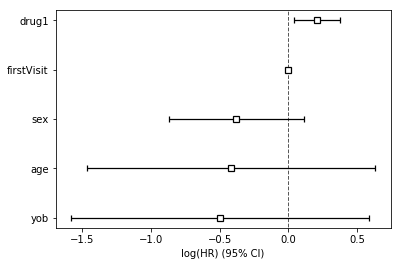

In [378]:
cph.plot()

In [21]:
df_Init[((df_Init[feat]==feat_present) & (df_Init['drug1']==drug))]['remission'].median()

408.0

In [22]:
from scipy import stats
feat = 'aCCP'
feat_present = 1
drug = ['hydroxychloroquine','methotrexaat', 'sulfasalazine'][1]
drug2 = ['hydroxychloroquine','methotrexaat', 'sulfasalazine'][0]
test = 'f'
l_size1 = list(df_Init[((df_Init[feat]==feat_present) & (df_Init['drug1']==drug))]['status'].value_counts().values)
l_label1 = list(df_Init[((df_Init[feat]==feat_present) & (df_Init['drug1']==drug))]['status'].value_counts().keys())
l_size2 = list(df_Init[((df_Init[feat]==feat_present) & (df_Init['drug1']==drug2))]['status'].value_counts().values)
l_label2 = list(df_Init[((df_Init[feat]==feat_present) & (df_Init['drug1']==drug2))]['status'].value_counts().keys())
print(l_size1, l_label1)
print(l_size2[::-1], l_label2[::-1]) # [::-1]
obs = np.array([l_size1, l_size2[::-1]])
if test == 'f':
    oddsratio, p = stats.fisher_exact(obs)
else :
    chi2, p, dof, ex = stats.chi2_contingency(obs, correction=True)#u
print('CHI squared (p):', p)

[55, 32] [1.0, 0.0]
[5, 25] [1.0, 0.0]
CHI squared (p): 1.28226095322077e-05


In [12]:
df_Init['status']

NameError: name 'df_Init' is not defined

In [508]:
def baselineChar(feat, df_Init):
    drugs = ['methotrexaat', 'hydroxychloroquine']
    characteristics = ['sex', 'RFC', 'status'] 
    for feat_present in range(0,2):
        for d in drugs:
            #print(d)
            df = df_Init[((df_Init[feat]==feat_present) & (df_Init['drug1']==d))]
            print('N ' + str(d) + ' = ' + str(len(df)))
            print('DAS44 (start): ' + str(df['BeginDAS44'].median()) + ' (' + str(df['BeginDAS44'].min()) + '-' + str(df['BeginDAS44'].max()) + ') ')
            print('DAS44 N: ' + str(len([x for x in list(df['BeginDAS44']) if x == x])))
            print('MTTC: ' + str(df['TTC'].median()) + ' (' + str(df['TTC'].min()) + '-' + str(df['TTC'].max()) + ') ')
            print('MTTC N: ' + str(len([x for x in list(df['TTC']) if x == x])))
            print('TTR : ' + str(df[df['status']==1]['remission'].median()) + ' (' + str(df[df['status']==1]['remission'].min()) + '-' + str(df[df['status']==1]['remission'].max()) + ') ')
            print('TTR N: ' + str(len(list(df[df['status']==1]['remission']))))
            for char in characteristics:
                try :
                    print('prop. ' + char + ' = 0:' + str(dict(df[char].value_counts())[0]) + ' 1:'+ str(dict(df[char].value_counts())[1]))
                except: 
                    print('prop. ' + char + ' = ' + str(dict(df[char].value_counts())))
                #l_size1 = list(df[char].value_counts().values)
        
            print()
baselineChar('aCCP', df_Init)


N methotrexaat = 82
DAS44 (start): 2.95 (0.5-6.3) 
DAS44 N: 36
MTTC: 728.5 (21.0-2022.0) 
MTTC N: 82
TTR : 276.0 (21.0-1666.0) 
TTR N: 45
prop. sex = 0:27 1:55
prop. RFC = 0:37 1:8
prop. status = 0:37 1:45

N hydroxychloroquine = 19
DAS44 (start): 2.9000000000000004 (1.4-3.8) 
DAS44 N: 8
MTTC: 464.0 (13.0-1389.0) 
MTTC N: 19
TTR : 217.0 (14.0-283.0) 
TTR N: 9
prop. sex = 0:6 1:13
prop. RFC = 0:9 1:3
prop. status = 0:10 1:9

N methotrexaat = 87
DAS44 (start): 2.8 (1.3-4.3) 
DAS44 N: 35
MTTC: 1010.0 (21.0-2272.0) 
MTTC N: 87
TTR : 386.0 (35.0-1455.0) 
TTR N: 55
prop. sex = 0:33 1:54
prop. RFC = 0:4 1:53
prop. status = 0:32 1:55

N hydroxychloroquine = 30
DAS44 (start): 2.5 (0.8-3.7) 
DAS44 N: 17
MTTC: 679.0 (0.0-1855.0) 
MTTC N: 29
TTR : 567.0 (385.0-1169.0) 
TTR N: 5
prop. sex = 0:8 1:22
prop. RFC = {1.0: 18}
prop. status = 0:25 1:5



In [218]:
obs = np.array([[29, 10], [11, 5]])
chi2, p, dof, ex = stats.chi2_contingency(obs, correction=False)#u
print('CHI squared (p):', p)

CHI squared (p): 0.6714122646243601


In [216]:
from scipy import stats
oddsratio, pvalue = stats.fisher_exact([[65, 51], [41, 23]])
pvalue

0.7436555656616035

In [190]:
#print(class_drug1_grouping['status'].value_counts())
#class_drug1_grouping['status'].plot.bar()
from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

#clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
#clf = MultinomialNB()
clf.fit(X_train, y_train)
#clf.score(X_test, y_test)
test_classifier(clf)
#test_classifier(clf_dt)

Accuracy: 0.5196 (+/- 0.06)


In [187]:
shuffle_validator = model_selection.ShuffleSplit(len(X), test_size=0.2, random_state=777)
def test_classifier(clf):
    scores = model_selection.cross_val_score(clf, X, y, cv=shuffle_validator)
    print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))


## No initial MTX subselection

In [77]:
df_tableTest['BeginDat'] = pd.to_datetime(df_tableTest['BeginDat'], format="%d-%m-%Y")
df_initial = df_tableTest.sort_values(by="BeginDat").groupby('PATNR').first() #df_noMTX
#df_initial_desc = df_tableTest.sort_values(by="BeginDat", ascending=False).groupby('PATNR').first()
l_MTX = list(df_initial[df_initial['drug']=='methotrexaat'].index)
#l_MTX.extend(list(df_initial_desc[df_initial_desc['drug']=='methotrexaat'].index))
df_noMTX= df_tableTest[~(df_tableTest['PATNR'].isin(l_MTX))]

In [78]:
df_patDF2 = df_noMTX.copy()
idx = df_patDF2.groupby(['PATNR'])['duration'].transform(max) == df_patDF2['duration']
df_patDF2 = df_patDF2[idx]
df_patDF2 = df_patDF2.drop_duplicates('PATNR')

In [33]:
l_firstDat = df_initial['BeginDat']
def firstDate(row):
    if row['BeginDat'] == l_firstDat[row['PATNR']]:
        row['keeper'] = 1
    else :
        row['keeper'] = 0
    return row

df_noMTX['keeper'] = df_noMTX['smoking']
df_noMTX = df_noMTX.apply(lambda x: firstDate(x), axis = 1)
df_noMTX_fin = df_noMTX[(df_noMTX['keeper'] == 1)]
df_noMTX_fin = df_noMTX_fin[df_noMTX_fin['drug'] != 'methotrexaat']
#df_noMTX['keeper']

G:\newAnacondaG\modules\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [39]:
df_MTX_fin = df_patDF[~(df_patDF['PATNR'].isin(list(df_noMTX_fin['PATNR'].unique())))]
print(len(df_MTX_fin))

262


In [332]:
df_patDF

,PATNR,drug,BeginDat,EindDat,BeginDAS44,BeginDAS44_datum,Bezdat0,ID,RFC,RemissieDat,...,yearOfBirth,duration,remission,drugCode,yob,age,firstVisit,incl,status,durationCOX
0,7800.0,methotrexaat,2012-09-13,09-01-2014,NaN,NaN,13-09-2012,methotrexaat718,0.0,06-06-2013,...,1957.0,483.0,266.0,12,2,2,13,55.0,True,266.0
2,102309.0,tocilizumab,2011-12-12,13-11-2017,3.3,12-12-2011,08-11-2011,tocilizumab382,1.0,31-05-2012,...,1937.0,2197.0,205.0,15,1,3,13,74.0,True,205.0
126,614879.0,methotrexaat,2012-08-17,22-12-2017,NaN,NaN,12-07-2012,methotrexaat7505,1.0,20-08-2013,...,1972.0,1989.0,404.0,12,3,1,13,40.0,True,404.0
174,334769.0,methotrexaat,2015-07-13,12-07-2017,2.8,13-07-2015,28-11-2011,methotrexaat296,1.0,19-11-2012,...,1971.0,2053.0,357.0,12,3,1,13,40.0,True,357.0
236,492022.0,sulfasalazine,2014-01-16,12-05-2016,3.4,16-01-2014,05-12-2011,sulfasalazine5990,1.0,10-04-2012,...,1942.0,1620.0,127.0,14,1,3,13,69.0,True,127.0
416,985572.0,hydroxychloroquine,2013-04-25,26-01-2017,3.6,25-04-2013,29-11-2012,hydroxychloroquine7800,1.0,19-12-2013,...,1958.0,1519.0,385.0,9,2,2,13,54.0,True,385.0
541,836105.0,rituximab,2016-05-27,08-07-2016,NaN,27-05-2016,31-05-2012,rituximab10109,0.0,NaT,...,1944.0,1499.0,0.0,13,1,3,13,68.0,False,1499.0
546,415546.0,methotrexaat,2011-11-24,24-07-2017,3.3,24-11-2011,15-11-2011,methotrexaat6612,1.0,06-06-2013,...,1965.0,2078.0,569.0,12,3,1,13,46.0,True,569.0
561,72838.0,methotrexaat,2012-08-15,13-03-2018,NaN,NaN,01-08-2012,methotrexaat5654,1.0,06-03-2014,...,1947.0,2050.0,582.0,12,2,2,13,65.0,True,582.0
639,414545.0,leflunomide,2012-12-06,26-02-2018,2.9,06-12-2012,02-07-2012,leflunomide7788,1.0,29-08-2014,...,1961.0,2065.0,788.0,11,3,1,13,51.0,True,788.0


In [18]:
df_patUnique = df_tableTest.copy()
df_patUnique = df_patUnique.drop_duplicates('PATNR')

feature = 'RFC'
subset_var = 'aCCP'
criteria = 0

print(list(df_patUnique[df_patUnique[subset_var]==criteria][feature].value_counts().values))
print(list(df_patUnique[df_patUnique[subset_var]==criteria][feature].value_counts().keys()))

print(list(df_patUnique[df_patUnique[subset_var]==criteria+1][feature].value_counts().values))
print(list(df_patUnique[df_patUnique[subset_var]==criteria+1][feature].value_counts().keys()))

print(list(df_patUnique[df_patUnique[subset_var]==criteria+2][feature].value_counts().values))
print(list(df_patUnique[df_patUnique[subset_var]==criteria+2][feature].value_counts().keys()))

[58, 15]
[0.0, 1.0]
[110, 8]
[1.0, 0.0]
[]
[]


## Time to remission differences ACPA+ and ACPA- subsets

In [25]:
#df_patUnique[((df_patUnique[subset_var]==0) & (df_patUnique['status']==1))][feature].median()

In [475]:
from scipy.stats import mannwhitneyu, ttest_ind

feature = 'remission' 
subset_var = 'aCCP'

rem = mannwhitneyu(df_patUnique[((df_patUnique[subset_var]==0) & (df_patUnique['status']==1))][feature],df_patUnique[((df_patUnique[subset_var]==1) & (df_patUnique['status']==1))][feature])

feature = 'incl'
subset_var = 'aCCP'

age = ttest_ind(df_patUnique[((df_patUnique[subset_var]==0) & (df_patUnique['status']==1))][feature],df_patUnique[((df_patUnique[subset_var]==1) & (df_patUnique['status']==1))][feature])

print(rem)
print(age)

MannwhitneyuResult(statistic=5039.0, pvalue=0.004819139136549499)
Ttest_indResult(statistic=3.017663158254774, pvalue=0.0028353853255936546)


In [474]:
#print(len(df_patUnique[((df_patUnique[subset_var]==criteria) & (df_patUnique['status']==1))]))
#print(len(df_patUnique[((df_patUnique[subset_var]==1) & (df_patUnique['status']==1))]))

df_patUnique[subset_var]==1

NameError: name 'df_patUnique' is not defined

In [384]:
feature = 'yearOfBirth'
subset_var = 'aCCP'

age = mannwhitneyu(df_patUnique[((df_patUnique[subset_var]==0) & (df_patUnique['status']==1))][feature],df_patUnique[((df_patUnique[subset_var]==1) & (df_patUnique['status']==1))][feature])

0.004

In [379]:
np.corrcoef(a,b)

NameError: name 'mannwhitneyu' is not defined

In [390]:
oddsratio, pvalue = stats.fisher_exact([[110, 8], [15, 58]])
pvalue

6.006242114004238e-26

In [370]:
print(len('100000000000000000000000000')-1)

27


In [45]:
print(list(df_noMTX_fin[feature].value_counts().values))
print(list(df_MTX_fin[feature].value_counts().values))


[41, 28, 25]
[94, 87, 81]


C:\Users\tdmaarseveen\AppData\Roaming\Python\Python36\site-packages\matplotlib\legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


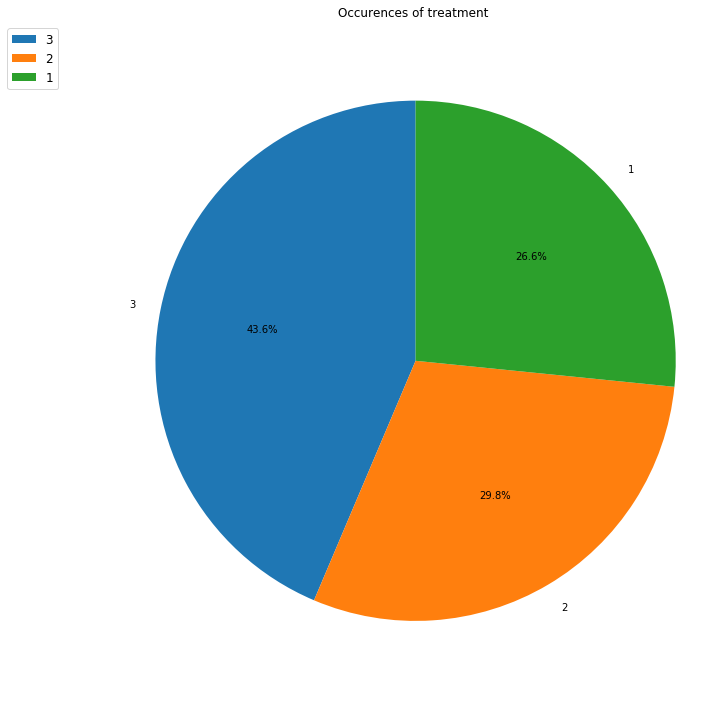

In [46]:

import matplotlib.pyplot as plt
# Create a list of colors (from iWantHue)
fig = plt.figure(figsize=[10, 10])
# Create a pie chart
plt.pie(
    # using data total)arrests
    list(df_noMTX_fin[feature].value_counts().values),
    # with the labels being officer names
    labels=list(df_noMTX_fin[feature].value_counts().keys()),
    # with no shadows
    shadow=False,
    # with one slide exploded out
    #explode=(0, 0, 0, 0, 0.15),
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',
    )

# View the plot drop above
plt.axis('equal', labeldistance=1.05)
plt.title('Occurences of treatment')
plt.legend(list(df_noMTX_fin[feature].value_counts().values), labels=list(df_noMTX_fin[feature].value_counts().keys()), loc="best", bbox_to_anchor=(-0.1, 1., 0., 0.), fontsize='large')

# View the plot
plt.tight_layout()
plt.show()

### Visualize Missingness

In [82]:
#msno.heatmap(df_tableTest)

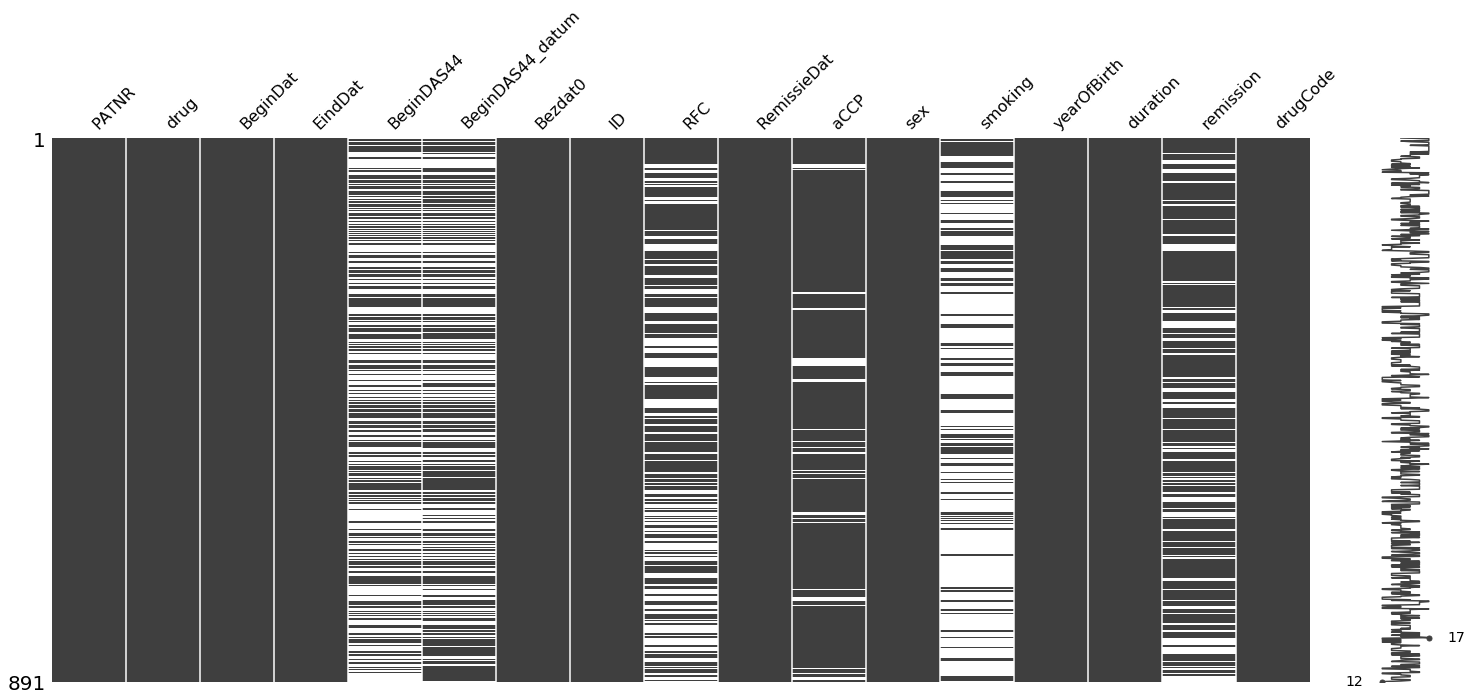

In [79]:
import missingno as msno

msno.matrix(df_tableTest)#.show()

#print(msno.__version__)

In [252]:
print(MEDICINE)

NameError: name 'MEDICINE' is not defined

In [271]:
print(len(palette))

12


In [427]:
from acronyms import MEDICINE
from matplotlib.pyplot import hsv
d_color = {}
count = 0
palette = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'red', 'blue', 'yellow', 'green', 'purple', 'pink', 'sienna', 'aqua', 'cyan', 'magenta', 'navy', 'maroon', 'teal', 'orange', 'brown']# viridis(18)
for drug in MEDICINE:
    if drug not in ['prednison', 'prednisolon', 'depomedrol']: 
        d_color[drug] = palette[count]
        count+=1
print(d_color)

{'methotrexaat': 'yellowgreen', 'leflunomide': 'gold', 'sulfasalazine': 'lightskyblue', 'hydroxychloroquine': 'lightcoral', 'azathioprine': 'red', 'ciclosporine': 'blue', 'goud': 'yellow', 'abatacept': 'green', 'adalimumab': 'purple', 'anakinra': 'pink', 'certolizumab': 'sienna', 'etanercept': 'aqua', 'golimumab': 'cyan', 'infliximab': 'magenta', 'rituximab': 'navy', 'tocilizumab': 'maroon', 'tofacitinib': 'teal', 'baricitinib': 'orange'}


In [9]:
[k,v for k,v in df_patDF[df_patDF['yob']==yob][feature].value_counts() if v >= pthreshold]

SyntaxError: invalid syntax (<ipython-input-9-dac5f380238e>, line 1)

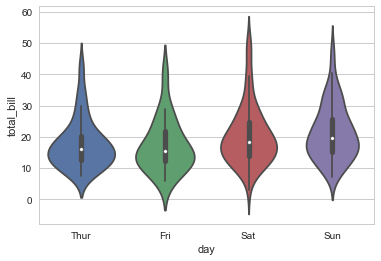

In [5]:
import seaborn as sns
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
#ax = sns.violinplot(x=tips["total_bill"])
ax = sns.violinplot(x="day", y="total_bill", data=tips)

<Figure size 864x864 with 0 Axes>

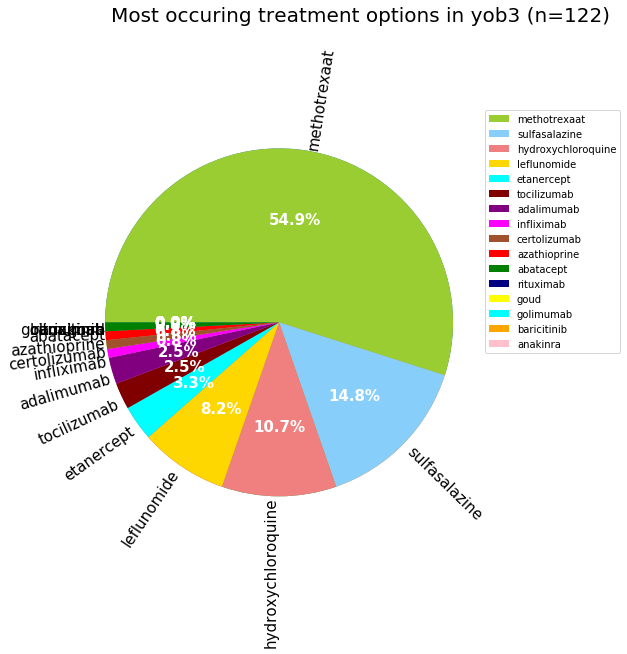

In [428]:
import matplotlib.pyplot as plt
feature = 'drug'
yob = 3

plt.figure(figsize=[12, 12])
includedict = dict(k,v for k,v in df_patDF[df_patDF['yob']==yob][feature].value_counts() if v >= pthreshold)
others = dict(k,v for k,v in df_patDF[df_patDF['yob']==yob][feature].value_counts() if v < pthreshold)

group_size=list(df_patDF[df_patDF['yob']==yob][feature].value_counts().values)
labels=list(df_patDF[df_patDF['yob']==yob][feature].value_counts().keys())
colors = []
for drug in labels:
    colors.append(d_color[drug])
#colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
fig, ax = plt.subplots()
ax.axis('equal')

pie1 = ax.pie(group_size, radius=2,  rotatelabels = 90, startangle=180,counterclock=False, autopct='%1.1f%%', textprops={'fontsize': 15 , 'color': 'white', 'weight':'bold'})
pie2 = ax.pie(group_size, radius=2,  colors=colors, labeldistance=1.0, labels=labels, rotatelabels = 90,
startangle=180,counterclock=False, textprops={'fontsize': 15})

#plt.title('Occurences of treatment')
plt.suptitle('Most occuring treatment options in yob3 (n='+ str(len(df_patDF[df_patDF['yob']==yob])) + ')', size=20, y=1.60, x=.70);   
plt.legend(bbox_to_anchor=(1.10, -0.2, 0.2, 1.7))

#pie = ax.pie(group_size, radius=2.05, colors=['k'] ,startangle=180,counterclock=False)
# View the plot
#plt.tight_layout()
plt.show()

In [327]:
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

rossi_dataset = load_rossi()

cph = CoxPHFitter()
cph.fit(rossi_dataset, duration_col='week', event_col='arrest', show_progress=True)

cph.print_summary()  # access the results using cph.summary

Iteration 1: norm_delta = 0.50881, step_size = 0.9500, ll = -675.38063, newton_decrement = 16.76434, seconds_since_start = 0.9
Iteration 2: norm_delta = 0.13852, step_size = 0.9500, ll = -659.79004, newton_decrement = 0.99157, seconds_since_start = 0.9
Iteration 3: norm_delta = 0.01802, step_size = 0.9500, ll = -658.76197, newton_decrement = 0.01422, seconds_since_start = 0.9
Iteration 4: norm_delta = 0.00108, step_size = 1.0000, ll = -658.74771, newton_decrement = 0.00005, seconds_since_start = 0.9
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -658.74766, newton_decrement = 0.00000, seconds_since_start = 0.9
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -658.75
  time fit was run = 2019-04-25 11:58:05 UTC

---
      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper

## Create Sample for Baseline table

In [419]:
import numpy as np
df_tableTest['duration'] = (pd.to_datetime(df_tableTest['EindDat'], format="%d-%m-%Y") - pd.to_datetime(df_tableTest['Bezdat0'], format="%d-%m-%Y")).dt.days
df_tableTest['remission'] = (pd.to_datetime(df_tableTest['RemissieDat'], format="%d-%m-%Y") - pd.to_datetime(df_tableTest['Bezdat0'], format="%d-%m-%Y")).dt.days
df_tableTest['status'] = ((df_tableTest['remission'] != 0) & (~df_tableTest['remission'].isna()))
#df_tableTest['duration']
df_tableTest.drug = pd.Categorical(df_tableTest.drug)
df_tableTest['drugCode'] = df_tableTest.drug.cat.codes 

In [13]:
df_patDF = df_tableTest.copy()
#df_patDF['duration'] = df_patDF['PATNR'].map(df_tableTest.groupby('PATNR')['duration'].max())
idx = df_patDF.groupby(['PATNR'])['duration'].transform(min) == df_patDF['duration']
df_patDF = df_patDF[idx]
df_patDF = df_patDF.drop_duplicates('PATNR')

#groups = df_tableTest[df_tableTest['duration']<=df_tableTest].groupby('PATNR')
#groups['duration'].max()
df_sample2 = df_patDF[['duration', 'remission', 'sex', 'smoking', 'RFC', 'yearOfBirth', 'BeginDAS44', 'drugCode', 'aCCP']] # translate 'drug',
#df_sample2 = df_sample2.fillna(0) 
df_sample2.head(20)

#df_patDF['remission']
df_patDF['durationCOX'] = df_patDF.apply(
    lambda row: row['duration'] if np.isnan(row['remission']) else row['remission'],
    axis=1
)
# df['c'] =

In [464]:
print(len(df_patDF[((df_patDF['aCCP']==1) & (~df_patDF['remission'].isna()))]))
print(len(df_patDF[((df_patDF['aCCP']==0) & (~df_patDF['remission'].isna()))]))

144
89


[]

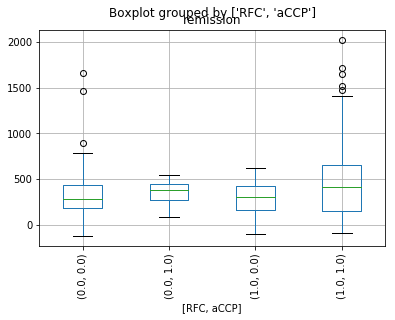

In [16]:
#feature_list = ['aCCP']
ax = df_patDF.boxplot(column=['remission'], by=["RFC", "aCCP"])# , "sex", "RFC"
#for x in feature_list:
    
#lbls = ['000', '001', '010', '100', '011', '101', '']
ax.set_xticklabels(ax.get_xticklabels(), rotation=90) # rotation_mode="anchor"
ax.plot()
#plt.show()
# , "sex", "RFC"

### Distribution Time to Remission (ACPA+ and ACPA-)

Text(0, 0.5, 'Nr of patients achieving remission')

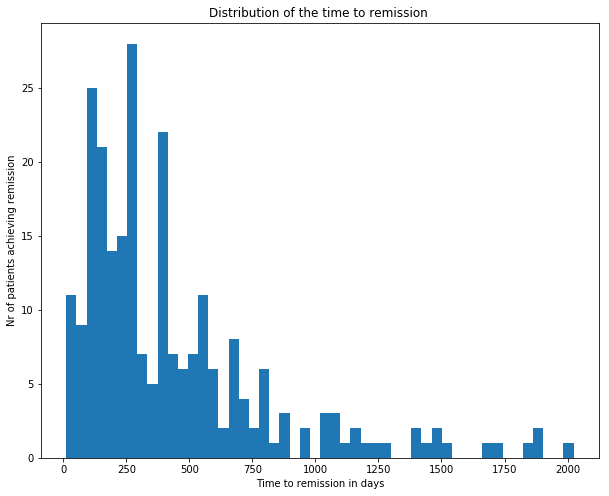

In [389]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))


plt.hist(df_patDF[((df_patDF['status']==1))]['remission'], label='aCCP+', bins=50)
#plt.hist(df_patDF[((df_patDF['status']==1))]['remission'], label='aCCP-', bins=50)
plt.title('Distribution of the time to remission ')
#plt.legend(loc='upper right')
plt.xlabel('Time to remission in days')
plt.ylabel('Nr of patients achieving remission')

Text(0, 0.5, 'Nr of patients')

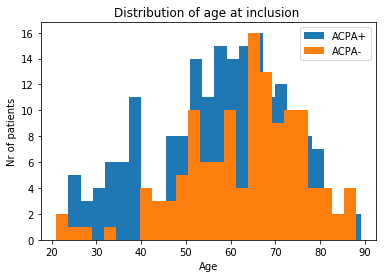

In [390]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))


plt.hist(df_patDF[df_patDF['aCCP']==1]['incl'], label='ACPA+', bins=25)
plt.hist(df_patDF[df_patDF['aCCP']==0]['incl'], label='ACPA-', bins=25)
plt.title('Distribution of age at inclusion ')
plt.legend(loc='upper right')
plt.xlabel('Age')
plt.ylabel('Nr of patients')

In [4]:
import numpy as np 
import pylab 
import scipy.stats as stats

measurements = np.random.normal(loc = 20, scale = 5, size=100)
plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
stats.probplot(df_patDF[((df_patDF['aCCP']==0))]['incl'], dist="norm", plot=plt)
plt.ylabel("Age at inclusion")
plt.title("ACPA-")
ax1 = plt.subplot(122)
stats.probplot(df_patDF[((df_patDF['aCCP']==1))]['incl'], dist="norm", plot=plt)

for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()-.03, i.get_y()+.5, \
            str(round((i.get_y()/total)*100, 2))+'%', fontsize=15,
                color='dimgrey')
ax.set_xticklabels(labels)

plt.title("ACPA+")
plt.ylabel("")
plt.suptitle("Quantile-Quantile plot for age at inclusion", size=20, y=1.10)
plt.show()

NameError: name 'plt' is not defined

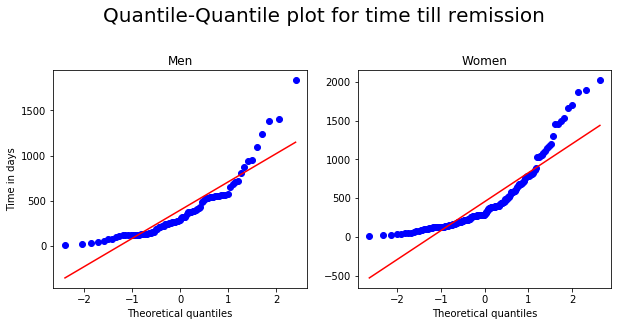

In [392]:
measurements = np.random.normal(loc = 20, scale = 5, size=100)
plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
stats.probplot(df_patDF[((df_patDF['sex']==0) & (df_patDF['status']==1))]['remission'], dist="norm", plot=plt)
plt.ylabel("Time in days")
plt.title("Men")
ax1 = plt.subplot(122)
stats.probplot(df_patDF[((df_patDF['sex']==1) & (df_patDF['status']==1))]['remission'], dist="norm", plot=plt)

plt.title("Women")
plt.ylabel("")
plt.suptitle("Quantile-Quantile plot for time till remission", size=20, y=1.10)
plt.show()

In [418]:
print(len(df_sample2['aCCP']))
print(len(df_sample2[df_sample2['remission'].isna()]))
print(len(df_sample2[df_sample2['aCCP']==1]['remission']))
print(len(df_sample2[df_sample2['aCCP']==0]['remission']))

342
96
188
128


### Create Blinded Dataframe

In [ ]:
print(df_blinded[['PATNR']==])

In [86]:
import random as rand
print(len(df_tableTest['PATNR'].unique()))
d_new = {}
for pat in df_tableTest['PATNR'].unique():
    d_new[pat] = rand.randint(1,1000000)
new_df = df_tableTest.replace({"PATNR": d_new})
print(len(new_df['PATNR'].unique()))
new_df.to_csv(r'Test/DF_BLIND_tableNetwork.csv', sep='|', index=True)

350
350


## Baseline comparison Median Time to remission

In [53]:
#df_sample2[df_sample2['aCCP']==0]

In [78]:
#stats.wilcoxon(df_sample2[df_sample2['aCCP']==1]['remission'], df_sample2[df_sample2['aCCP']==0]['remission'])

stats.ttest_ind(200,344)

G:\newAnacondaG\modules\lib\site-packages\numpy\core\fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
G:\newAnacondaG\modules\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
G:\newAnacondaG\modules\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
G:\newAnacondaG\modules\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
G:\newAnacondaG\modules\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Ttest_indResult(statistic=nan, pvalue=nan)

## Quantity Achieving remission in ACPA(+) vs ACPA(-)
applying Chi squared test to assess differences in the 

In [408]:
print(len(df_sample2))
print(len(df_sample2[~(df_sample2['remission']<0 | df_sample2['remission'].isna())]))
df_sample2[~(df_sample2['remission']<0 | df_sample2['remission'].isna())].head()

346
346


,duration,remission,sex,smoking,RFC,yearOfBirth,BeginDAS44,drugCode,aCCP
0,483.0,266.0,1.0,NaN,0.0,1957.0,NaN,12,0.0
2,2197.0,205.0,1.0,7.0,1.0,1937.0,3.3,15,1.0
126,1989.0,404.0,1.0,NaN,1.0,1972.0,NaN,12,1.0
174,2053.0,357.0,0.0,7.0,1.0,1971.0,2.8,12,1.0
236,1620.0,127.0,0.0,7.0,1.0,1942.0,3.4,14,1.0


### Assess DAS for baseline in ACPA+ vs ACPA-

In [24]:
feature = 'aCCP'
present = 1
l_das1 = list(df_sample2[(df_sample2[feature]==present)]['remission'])
#print(len(l_nonan))
l_das1 = [x for x in l_das1 if x == x]
print('N of DAS44: ', len(l_das1))
print('Max DAS44: ', max(l_das1))
print('Min DAS44: ', min(l_das1))
print('Median DAS44: ', df_sample2[(df_sample2[feature]==present)]['remission'].median())

N of DAS44:  144
Max DAS44:  2024.0
Min DAS44:  -264.0
Median DAS44:  396.5


In [472]:
from scipy.stats import mannwhitneyu, ttest_ind

feature = 'BeginDAS44' 
subset_var = 'aCCP'

rem = mannwhitneyu(df_sample2[(df_sample2[subset_var]==0)][feature],df_sample2[(df_sample2[subset_var]==1)][feature])

print(rem)

MannwhitneyuResult(statistic=9795.0, pvalue=0.0010547094651114936)


In [441]:
feature = 'aCCP'

print(len(df_sample2[(df_sample2[feature]==1.0) & (df_sample2['sex']==1)]))
print(len(df_sample2[(df_sample2[feature]==0.0) & (df_sample2['sex']==1)]))

134
82


In [86]:
# Chi
obs = np.array([[89, 39], [144, 46]])
chi2, p, dof, ex = chi2_contingency(obs, correction=False)#u
print('CHI squared (p):', p)

CHI squared (p): 0.21620414416724598


In [398]:
import scipy
import scipy.stats as stats
import numpy as np
from scipy.stats import chi2_contingency

feature = 'aCCP'
#df_chi = df_sample2[(~df_sample2['aCCP'].isna())]
grp1_pos = len(df_sample2[(df_sample2[feature]==1.0) & (~df_sample2['remission'].isna())])
grp1_neg = len(df_sample2[(df_sample2[feature]==1.0) & (df_sample2['remission'].isna())])
grp2_pos = len(df_sample2[(df_sample2[feature]==0.0) & (~df_sample2['remission'].isna())])
grp2_neg = len(df_sample2[(df_sample2[feature]==0.0) & (df_sample2['remission'].isna())])
print('Group 1:',grp1_pos, grp1_neg, 'Group 2:', grp2_pos, grp2_neg)

# Chi
obs = np.array([[grp1_pos, grp1_neg], [grp2_pos, grp2_neg]])
chi2, p, dof, ex = chi2_contingency(obs, correction=False)#u
print('CHI squared (p):', p)
#print(chi2, dof, ex)

Group 1: 144 46 Group 2: 89 39
CHI squared (p): 0.21620414416724598


## ACPA positivity in the RF+ and RF- group
to add -> percentage missingness (for both groups)
        -> percentage remission achieved (for both groups)

In [243]:
# Chi
obs = np.array([[110, 18], [8, 63]])
chi2, p, dof, ex = chi2_contingency(obs, correction=True)
print('CHI squared (p):', p)

CHI squared (p): 4.4750785098775985e-24


## RF positivity in the ACPA+ and ACPA- group

In [245]:
# ACPA+RF+, ACPA+RF-, ACPA-RF+, ACPA
obs = np.array([[110, 82], [15, 112]])
chi2, p, dof, ex = chi2_contingency(obs, correction=True)
print('CHI squared (p):', p)

CHI squared (p): 9.878149441722063e-16


### Initial MTX respons (Achieving clinical Remission) Female vs Male

In [208]:
# Chi
from scipy.stats import chi2_contingency

obs = np.array([[79, 86], [53, 36]])
chi2, p, dof, ex = chi2_contingency(obs, correction=False)
print('CHI squared (p):', p)

CHI squared (p): 0.07567842744263818


In [26]:
df_sample = df_tableTest[['duration', 'remission', 'sex', 'smoking', 'RFC', 'yearOfBirth', 'BeginDAS44', 'drugCode', 'aCCP']] # translate 'drug',
df_sample['remission'] = df_sample['remission'].fillna(0) 
df_sample.head()

G:\newAnacondaG\modules\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,duration,remission,sex,smoking,RFC,yearOfBirth,BeginDAS44,drugCode,aCCP
0,0.0,266.0,1.0,NaN,0.0,1957.0,0.9,12,0.0
2,34.0,205.0,1.0,7.0,1.0,1937.0,3.3,15,1.0
33,332.0,205.0,1.0,7.0,1.0,1937.0,3.3,12,1.0
64,1115.0,205.0,1.0,7.0,1.0,1937.0,3.3,11,1.0
95,1288.0,205.0,1.0,7.0,1.0,1937.0,3.3,9,1.0


In [209]:
df_sample['sex'].unique()

NameError: name 'df_sample' is not defined

In [301]:
#df_sample2['status']
df_patDF #.head()

,PATNR,drug,BeginDat,EindDat,BeginDAS44,BeginDAS44_datum,Bezdat0,ID,RFC,RemissieDat,...,yearOfBirth,duration,remission,drugCode,yob,age,firstVisit,incl,status,durationCOX
0,7800.0,methotrexaat,2012-09-13,09-01-2014,NaN,NaN,13-09-2012,methotrexaat718,0.0,06-06-2013,...,1957.0,483.0,266.0,12,2,2,13,55.0,True,266.0
2,102309.0,tocilizumab,2011-12-12,13-11-2017,3.3,12-12-2011,08-11-2011,tocilizumab382,1.0,31-05-2012,...,1937.0,2197.0,205.0,15,1,3,13,74.0,True,205.0
126,614879.0,methotrexaat,2012-08-17,22-12-2017,NaN,NaN,12-07-2012,methotrexaat7505,1.0,20-08-2013,...,1972.0,1989.0,404.0,12,3,1,13,40.0,True,404.0
174,334769.0,methotrexaat,2015-07-13,12-07-2017,2.8,13-07-2015,28-11-2011,methotrexaat296,1.0,19-11-2012,...,1971.0,2053.0,357.0,12,3,1,13,40.0,True,357.0
236,492022.0,sulfasalazine,2014-01-16,12-05-2016,3.4,16-01-2014,05-12-2011,sulfasalazine5990,1.0,10-04-2012,...,1942.0,1620.0,127.0,14,1,3,13,69.0,True,127.0
416,985572.0,hydroxychloroquine,2013-04-25,26-01-2017,3.6,25-04-2013,29-11-2012,hydroxychloroquine7800,1.0,19-12-2013,...,1958.0,1519.0,385.0,9,2,2,13,54.0,True,385.0
541,836105.0,rituximab,2016-05-27,08-07-2016,NaN,27-05-2016,31-05-2012,rituximab10109,0.0,NaT,...,1944.0,1499.0,NaN,13,1,3,13,68.0,False,1499.0
546,415546.0,methotrexaat,2011-11-24,24-07-2017,3.3,24-11-2011,15-11-2011,methotrexaat6612,1.0,06-06-2013,...,1965.0,2078.0,569.0,12,3,1,13,46.0,True,569.0
561,72838.0,methotrexaat,2012-08-15,13-03-2018,NaN,NaN,01-08-2012,methotrexaat5654,1.0,06-03-2014,...,1947.0,2050.0,582.0,12,2,2,13,65.0,True,582.0
639,414545.0,leflunomide,2012-12-06,26-02-2018,2.9,06-12-2012,02-07-2012,leflunomide7788,1.0,29-08-2014,...,1961.0,2065.0,788.0,11,3,1,13,51.0,True,788.0


In [314]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

df_patDF['remission'] = df_patDF['remission'].fillna(0) 
df_sample3 = df_patDF[['durationCOX', 'status', 'sex', 'drugCode', 'yob', 'aCCP', 'firstVisit', 'age']].dropna(axis=0)

kmf.fit(df_sample3['durationCOX'], event_observed=df_sample3['status'])

<lifelines.KaplanMeierFitter: fitted with 318 observations, 87 censored>

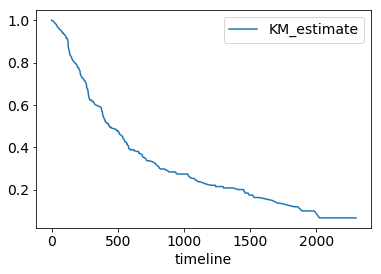

In [303]:
kmf.survival_function_
kmf.cumulative_density_
kmf.median_
kmf.survival_function_.plot()

In [223]:
#df_patDF['yob']

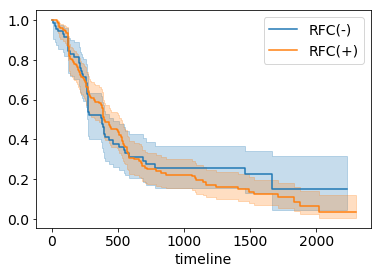

In [304]:
f = 'RFC'

kmf = KaplanMeierFitter()

kmf.fit(df_patDF[df_patDF[f]==0]['durationCOX'], df_patDF[df_patDF[f]==0]['status'], label='RFC(-)')
ax = kmf.plot()

kmf.fit(df_patDF[df_patDF[f]==1]['durationCOX'], df_patDF[df_patDF[f]==1]['status'], label='RFC(+)')
ax = kmf.plot(ax=ax)


In [30]:
df_sample3['aCCP'] = df_sample3['aCCP']*1

In [38]:
df_sample3

In [226]:
events = df_sample3['status']
print(df_sample3.loc[events, 'aCCP'].var())

0.23786937699981264


In [311]:
#df_sample3[df_sample3['status']==False]

In [227]:
print(len(df_sample3[df_sample3['status']==True]))
print(len(df_sample3[df_sample3['status']==False]))

231
87


In [107]:
#df_sample3[df_sample3['status']==False]

In [315]:
cph.fit(df_sample3, duration_col='durationCOX', event_col='status', show_progress=True)
# 'RFC',
cph.print_summary()  # access the results using cph.summary

Iteration 1: norm_delta = 0.32288, step_size = 0.9500, ll = -1155.42476, newton_decrement = 7.99767, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.06962, step_size = 0.9500, ll = -1146.90340, newton_decrement = 0.32967, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00723, step_size = 0.9500, ll = -1146.56469, newton_decrement = 0.00347, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.00040, step_size = 1.0000, ll = -1146.56122, newton_decrement = 0.00001, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -1146.56121, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 318 observations, 87 censored>
      duration col = 'durationCOX'
         event col = 'status'
number of subjects = 318
  number of events = 231
    log-likelihood = -1146.56
  time fit was run = 2019-04-24 12:24:45 UTC

---
            coef exp(coef)  se(coef)     z      p  -log2(p)  

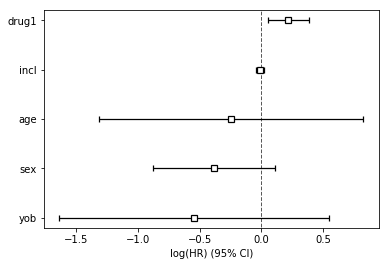

In [342]:
cph.plot()

In [2]:
#cph.plot_covariate_groups('drug1', range(500), cmap='coolwarm')

AttributeError: 'AxesSubplot' object has no attribute 'show'

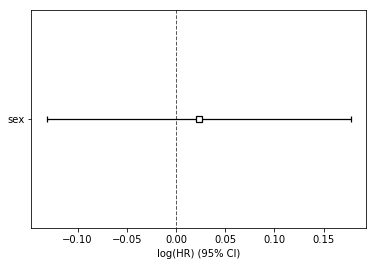

In [24]:
cph.plot()


In [91]:
new_df[new_df['RemissieDat']<new_df['BeginDat']].head()

,PATNR,drug,BeginDat,EindDat,BeginDAS44,BeginDAS44_datum,Bezdat0,ID,RFC,RemissieDat,aCCP,sex,smoking,yearOfBirth,duration,remission,drugCode
0,7800.0,methotrexaat,13-09-2012,09-01-2014,NaN,NaN,13-09-2012,methotrexaat718,0.0,06-06-2013,0.0,1.0,NaN,1957.0,0,266.0,12
138,334769.0,methotrexaat,20-01-2012,15-05-2013,NaN,NaN,28-11-2011,methotrexaat5665,1.0,19-11-2012,1.0,0.0,7.0,1971.0,53,357.0,12
210,492022.0,methotrexaat,24-01-2012,16-04-2014,NaN,NaN,05-12-2011,methotrexaat6610,1.0,10-04-2012,1.0,0.0,7.0,1942.0,257,511.0,12
236,492022.0,sulfasalazine,16-01-2014,12-05-2016,3.4,16-01-2014,05-12-2011,sulfasalazine5990,1.0,10-04-2012,1.0,0.0,7.0,1942.0,980,511.0,14
262,492022.0,hydroxychloroquine,16-01-2014,12-05-2016,3.4,16-01-2014,05-12-2011,hydroxychloroquine8322,1.0,10-04-2012,1.0,0.0,7.0,1942.0,980,511.0,9


In [1]:
#rossi_dataset